In [2]:
import numpy as np
import scipy as sc
import sympy as sp
from manim import Matrix
from openseespy import opensees as ops
import matplotlib.pyplot as plt

C:\Users\louis\anaconda3\envs\flamant\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
def truss_stiffness_matrix(nodes, elements, EA, supports):
    """
    Assemble the global stiffness matrix for a 2D truss using sympy.

    Parameters:
        nodes (dict): Dictionary of node coordinates {node_id: (x, y)}
        elements (list): List of tuples (node1, node2) defining element connectivity
        A (dict): Dictionary of cross-sectional areas {element_id: A_value}
        E (dict): Dictionary of Young's modulus values {element_id: E_value}

    Returns:
        sympy.Matrix: Global stiffness matrix
    """
    num_nodes = len(nodes)
    dof = 2 * num_nodes  # Degrees of freedom (2 per node)
    K_global = sp.zeros(dof, dof)

    for i, (n1, n2) in enumerate(elements):
        x1, y1 = nodes[n1]
        x2, y2 = nodes[n2]
        L = sp.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Element length
        c = (x2 - x1) / L  # Cosine of angle
        s = (y2 - y1) / L  # Sine of angle

        # Stiffness matrix for an element in local coordinates
        k_local = (EA[i] / L) * sp.Matrix([
            [c ** 2, c * s, -c ** 2, -c * s],
            [c * s, s ** 2, -c * s, -s ** 2],
            [-c ** 2, -c * s, c ** 2, c * s],
            [-c * s, -s ** 2, c * s, s ** 2]
        ])

        # Global DOF indices
        dof_indices = [2 * n1, 2 * n1 + 1, 2 * n2, 2 * n2 + 1]

        # Assemble into global stiffness matrix
        for r in range(4):
            for c in range(4):
                K_global[dof_indices[r], dof_indices[c]] += k_local[r, c]

        for i in supports:
            for j in range(K_global.shape[0]):
                K_global[i, j] = 0.
                K_global[j, i] = 0.
            K_global[i, i] = 1

    return K_global


def analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A_list, E_list):
    """
    Parameters:
        nodes: np.array of shape (n_nodes, 3)
        connectivity_matrix: np.array of shape (n_elements, 2)
        supports: dict {node_index: (fix_x, fix_y)}
        loads: dict {node_index: [Fx, Fy]}
        A_list: list of cross-sectional areas (length = n_elements)
        E_list: list of Young's moduli (length = n_elements)

    Returns:
        displacements: dict {node_index: [ux, uy]}
    """

    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 2)

    # Create nodes
    for i, (x, y, _) in enumerate(nodes):
        ops.node(i, x, y)

    # Supports
    for node_id, (fix_x, fix_y) in supports.items():
        ops.fix(node_id, int(fix_x), int(fix_y))

    # Define elements and materials
    for i, (ni, nj) in enumerate(connectivity_matrix):
        E = E_list[i]
        A = A_list[i]
        ops.uniaxialMaterial("Elastic", i, E)
        ops.element("truss", i, int(ni), int(nj), A, i)

    # Apply loads
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)
    for node_id, (Fx, Fy) in loads.items():
        ops.load(node_id, Fx, Fy)

    # Static analysis
    ops.system("SparseGeneral")
    ops.numberer("RCM")
    ops.constraints("Plain")
    ops.integrator("LoadControl", 1.0)
    ops.algorithm("Linear")
    ops.analysis("Static")
    ops.analyze(1)

    # Get displacements
    displacements = np.array([
        [ops.nodeDisp(i, 1), ops.nodeDisp(i, 2)]
        for i in range(len(nodes))
    ])

    forces = np.array([ops.eleResponse(i, 'axialForce')[0] for i in range(len(connectivity_matrix))])

    return displacements, forces

# Isostatic

In [4]:
nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
supports = {0: (True, True), 2: (False, True)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
loads = {1: [0., -1000.e3],
         2: [0, 0.],
         3: [0, 0]}

supports_dof = [2 * k + i for k, v in supports.items() for i, b in enumerate(v) if b]
mask = [i for i in range(2 * len(nodes)) if i not in supports_dof]

q_ = np.zeros(2 * len(nodes))
for k, (x, y) in loads.items():
    q_[2 * k] += x
    q_[2 * k + 1] += y

A = np.array([1] * 5, dtype=float)
E = np.array([525e6] * 5, dtype=float)

target = E * A

K_ = truss_stiffness_matrix(
    nodes[:, :2], connectivity_matrix, [sp.Symbol(f'EA{i}', real=True, positive=True) for i in range(5)],
    supports_dof
)
Kf = sp.lambdify(sorted(K_.free_symbols, key=lambda x: str(x)), K_, 'numpy')

u_, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

print("Vector u:")
print(r"\begin{bmatrix}")
for ui in u_.reshape(-1):
    print('\t' + rf"{ui * 1000:.2f} \\")
print(r"\end{bmatrix}" + '\n')

Kbb = K_[mask, :][:, mask]
ub = u_.reshape((-1, 1))[mask]
qb = q_.reshape((-1, 1))[mask]

eqs = Kbb @ ub - qb
vars = sorted(list(Kbb.free_symbols), key=lambda s: str(s))
rows = []

for eq in eqs:
    coeffs = [eq.coeff(v) for v in vars]
    const = -eq.subs({v: 0 for v in vars})  # move constant to the right-hand side
    rows.append(coeffs + [const])

augmented = sp.Matrix(rows)

rref_matrix, pivots = augmented.rref()
EA_pred = sp.matrix2numpy(rref_matrix.evalf()[:, -1])

print("Results:")
for i, EA_i in enumerate(EA_pred):
    print('\t' + rf"EA_{i} = " + f"{EA_i[0]}")

Vector u:
\begin{bmatrix}
	0.00 \\
	0.00 \\
	4.76 \\
	-27.75 \\
	9.52 \\
	0.00 \\
	4.76 \\
	-18.23 \\
\end{bmatrix}

Results:
	EA_0 = 525000000.000000
	EA_1 = 525000000.000000
	EA_2 = 525000000.000000
	EA_3 = 525000000.000000
	EA_4 = 525000000.000000


# Hyperstatic

In [5]:
nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 5, 0), (5, 5, 0)], dtype=float)
supports = {0: (True, True), 2: (True, True)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
supports_dof = [2 * k + i for k, v in supports.items() for i, b in enumerate(v) if b]
mask = [i for i in range(2 * len(nodes)) if i not in supports_dof]

A = np.array([1] * 5, dtype=float)
E = np.array([525e6] * 5, dtype=float)

target = E * A

K_ = truss_stiffness_matrix(
    nodes[:, :2], connectivity_matrix, [sp.Symbol(f'EA{i}', real=True, positive=True) for i in range(5)],
    supports_dof
)
Kf = sp.lambdify(sorted(K_.free_symbols, key=lambda x: str(x)), K_, 'numpy')

Kbb = K_[mask, :][:, mask]

eqs = []

loads = {1: [-1000.e3,0]}
u_, N_ = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
q_ = np.zeros(2 * len(nodes))
for k, (x, y) in loads.items():
    q_[2 * k] += x
    q_[2 * k + 1] += y
u_ = u_.reshape(-1)
q_ = q_.reshape(-1)
eqs.append(Kbb @ u_[mask] - q_[mask])

loads = {1: [0, -1000.e3]}
u_, N_ = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
q_ = np.zeros(2 * len(nodes))
for k, (x, y) in loads.items():
    q_[2 * k] += x
    q_[2 * k + 1] += y
u_ = u_.reshape(-1)
q_ = q_.reshape(-1)
eqs.append(Kbb @ u_[mask] - q_[mask])

loads = {3: [-1000.e3,0]}
u_, N_ = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
q_ = np.zeros(2 * len(nodes))
for k, (x, y) in loads.items():
    q_[2 * k] += x
    q_[2 * k + 1] += y
u_ = u_.reshape(-1)
q_ = q_.reshape(-1)
eqs.append(Kbb @ u_[mask] - q_[mask])

loads = {3: [0, -1000e3]}
u_, N_ = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
q_ = np.zeros(2 * len(nodes))
for k, (x, y) in loads.items():
    q_[2 * k] += x
    q_[2 * k + 1] += y
u_ = u_.reshape(-1)
q_ = q_.reshape(-1)
eqs.append(Kbb @ u_[mask] - q_[mask])

eqs = np.hstack(eqs)

vars = sorted(list(Kbb.free_symbols), key=lambda s: str(s))
A = []
b = []
for eq in eqs:
    coeffs = [eq.coeff(v) for v in vars]
    const = -eq.subs({v: 0 for v in vars})  # move constant to the right-hand side
    A.append(coeffs)
    b.append(const)

A = sp.Matrix(A)
b = sp.Matrix(b)
augmented = A.row_join(b)

rref_matrix, pivots = augmented.rref()
EA_pred = sp.matrix2numpy(rref_matrix.evalf()[:, -1])

print("Results:")
for i, EA_i in enumerate(EA_pred):
    print('\t' + rf"EA_{i} = " + f"{EA_i[0]}")

print("Actual solver:")
sp.solve(eqs, K_.free_symbols)

Results:
	EA_0 = 0
	EA_1 = 0
	EA_2 = 0
	EA_3 = 0
	EA_4 = 0
	EA_5 = 1.00000000000000
	EA_6 = 0
	EA_7 = 0
	EA_8 = 0
	EA_9 = 0
	EA_10 = 0
	EA_11 = 0
	EA_12 = 0
	EA_13 = 0
	EA_14 = 0
	EA_15 = 0
Actual solver:


[]

# Noise robustness

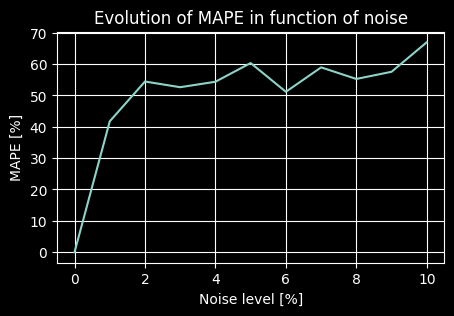

In [7]:
class AnalyticalMethodNoiseRobustness:
    def __init__(self, seed=1):
        np.random.seed(seed)

        nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 2: (False, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
        loads = {1: [-300.e3, -1500.e3],
                 2: [-100, 0.],
                 3: [1000e3, 2000e3]}

        supports_dof = [2 * k + i for k, v in supports.items() for i, b in enumerate(v) if b]
        mask = [i for i in range(2 * len(nodes)) if i not in supports_dof]

        q_ = np.zeros(2 * len(nodes))
        for k, (x, y) in loads.items():
            q_[2 * k] += x
            q_[2 * k + 1] += y

        A = np.random.uniform(.0, 2, 5)
        E = np.array([525e6] * 5, dtype=float)

        target = E * A

        K_ = truss_stiffness_matrix(
            nodes[:, :2], connectivity_matrix, [sp.Symbol(f'EA{i}', real=True, positive=True) for i in range(5)],
            supports_dof
        )

        symbols = sorted(K_.free_symbols, key=lambda s: str(s))

        u_, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
        #print('N')
        #print(N)
        Kbb = K_[mask, :][:, mask]
        ub = u_.reshape((-1, 1))[mask]
        qb = q_.reshape((-1, 1))[mask]

        Kbb_ = sp.matrix2numpy(Kbb.subs([symbol, ea] for symbol, ea in zip(symbols, target)), float)

        noise_values = np.linspace(0, .1, 11)
        mape_hist = []

        for noise in noise_values:
            mape_hist_trial = []
            for i in range(20):
                pred = self.test(noise, Kbb, ub, qb).reshape(-1)
                m = self.mape(pred, target.T)
                mape_hist_trial.append(m)
            mape_hist.append(mape_hist_trial)

        mape_hist = np.array(mape_hist)
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.set_title("Evolution of MAPE in function of noise")
        ax.plot(100 * noise_values, 100 * np.median(mape_hist, axis=1))
        ax.set_xlabel('Noise level [%]')
        ax.set_ylabel('MAPE [%]')
        ax.grid(True)
        fig.savefig("03-truss_example_noise_mape.pdf", bbox_inches='tight', pad_inches=0.0,transparent=True)
        plt.show()
        plt.close(fig)
        np.savetxt("analytical_mean_mape.dat", np.median(mape_hist, axis=1), delimiter='')

    @staticmethod
    def mape(x_pred, x):
        return np.mean(np.abs((x_pred - x) / x))

    @staticmethod
    def test(noise, Kbb, ub, qb):
        u = ub * np.random.normal(loc=1, scale=noise / 2, size=ub.shape)
        q = qb * np.random.normal(loc=1, scale=noise / 2, size=qb.shape)
        K = Kbb.copy()

        eqs = K @ u - q

        vars = sorted(list(K.free_symbols), key=lambda s: str(s))
        rows = []

        #sol = sp.solve(eqs, vars, dict=True)
        #print(sol)

        for eq in eqs:
            coeffs = [eq.coeff(v) for v in vars]
            const = -eq.subs({v: 0 for v in vars})  # move constant to the right-hand side
            rows.append(coeffs + [const])

        augmented = sp.Matrix(rows)

        rref_matrix, pivots = augmented.rref()
        EA_pred = sp.matrix2numpy(rref_matrix.evalf()[:, -1])
        return EA_pred

AnalyticalMethodNoiseRobustness()